In [3]:
from scipy.signal import butter, lfilter
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.signal import freqz, stft, spectrogram, iirpeak, filtfilt
from pathlib import Path
import h5py

In [4]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, axis=-1):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=axis)
    return y

def narrow_bandpass(center_frequency, quality_factor, sampling_frequency):
    w0 = center_frequency # Center frequency
    Q = quality_factor # Quality factor
    return iirpeak(w0, Q, fs=sampling_frequency)

def narrow_bandpass_filter(data, center_frequency, quality_factor, samplig_frequency, axis=-1):
    b, a = narrow_bandpass(center_frequency, quality_factor, samplig_frequency)
    y = lfilter(b, a, data, axis=axis)
    return y

Following the answer on [Stack Overflow](https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter)

In [5]:
def extract_amplitude_phase(movie, frequency, sampling_rate):
    """
    Extract amplitude and phase at each pixel using a sliding window with a length of exactly two periods.
    
    Parameters:
    movie (np.ndarray): 3D numpy array of shape (frames, height, width) representing the movie.
    frequency (float): Known frequency of the driving function.
    sampling_rate (float): Sampling rate of the movie.
    
    Returns:
    amplitude (np.ndarray): 3D numpy array of shape (frames, height, width) containing the amplitude.
    phase (np.ndarray): 3D numpy array of shape (frames, height, width) containing the phase.
    """
    frames, height, width = movie.shape
    period = 1.0 / frequency
    window_length = int(2 * period * sampling_rate)
    half_window_length = window_length // 2

    t = np.arange(window_length) / sampling_rate
    cos_filter = np.cos(2 * np.pi * frequency * t)
    sin_filter = np.sin(2 * np.pi * frequency * t)

    amplitude = np.zeros_like(movie, dtype=np.float32)
    phase = np.zeros_like(movie, dtype=np.float32)
    
    for i in range(half_window_length, frames - half_window_length):
        window = movie[i - half_window_length:i + half_window_length]

        cos_component = np.tensordot(window, cos_filter, axes=(0, 0))
        sin_component = np.tensordot(window, sin_filter, axes=(0, 0))

        amplitude[i] = np.sqrt(cos_component**2 + sin_component**2)
        phase[i] = np.arctan2(sin_component, cos_component)
    
    return amplitude, phase

# Refeyn data
Let's apply the same filtering to the Refeyn dataset

In [6]:
data_folder = Path("/Users/aquiles/Documents/Programs/refeyn")
filename = Path("015_100mVpp 1Hz.mp")

In [7]:
data_file = h5py.File(data_folder/filename, 'r')
data = data_file["movie/frame"][()]
freq = data_file["movie/configuration/acq_camera"]["frame_rate"][()]
N = data.shape[0]
print(data.shape)
print(f'Framerate {freq:3.4}Hz')

(5094, 128, 128)
Framerate 339.6Hz


In [8]:
## Quick data exploration

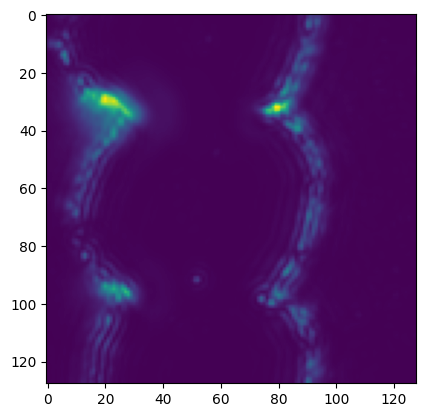

In [9]:
plt.imshow(data[500, ...])

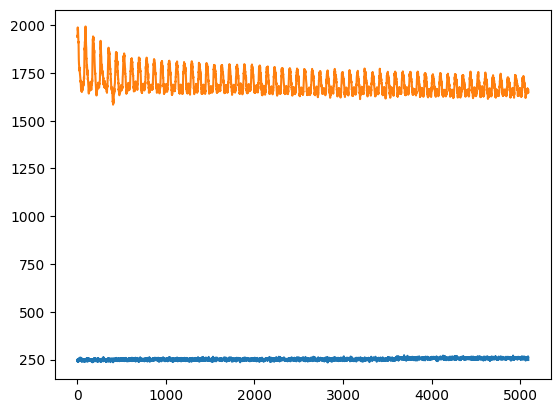

In [10]:
plt.plot(data[:, 60, 60])
plt.plot(data[:, 20, 20])
plt.show()

## Let's find the most appropriate component for the filtering

In [11]:
transformed = fft(data[:, 20, 20])
freqs = fftfreq(N, 1/freq)[:N//2]
power = 2.0/N * np.abs(transformed[0:N//2])

In [12]:
n_max = np.argmax(power[1:])+1
max_freq = freqs[n_max]
print(f'Maximum frequency in FFT: {max_freq}Hz')

Maximum frequency in FFT: 4.00038648409894Hz


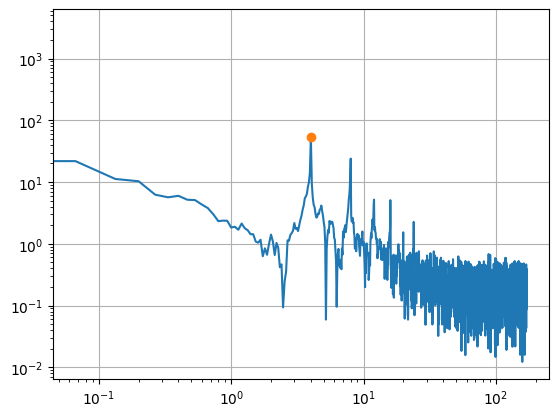

In [13]:
plt.plot(freqs, power)
plt.plot(max_freq, power[n_max], 'o')
plt.grid()
plt.yscale('log')
plt.xscale('log')

## Is the frequency stable over time?

In [14]:
f, t, Sxx = spectrogram(data, fs=freq, axis=0, mode='complex', noverlap=128)

Text(0.5, 0, 'Time (s)')

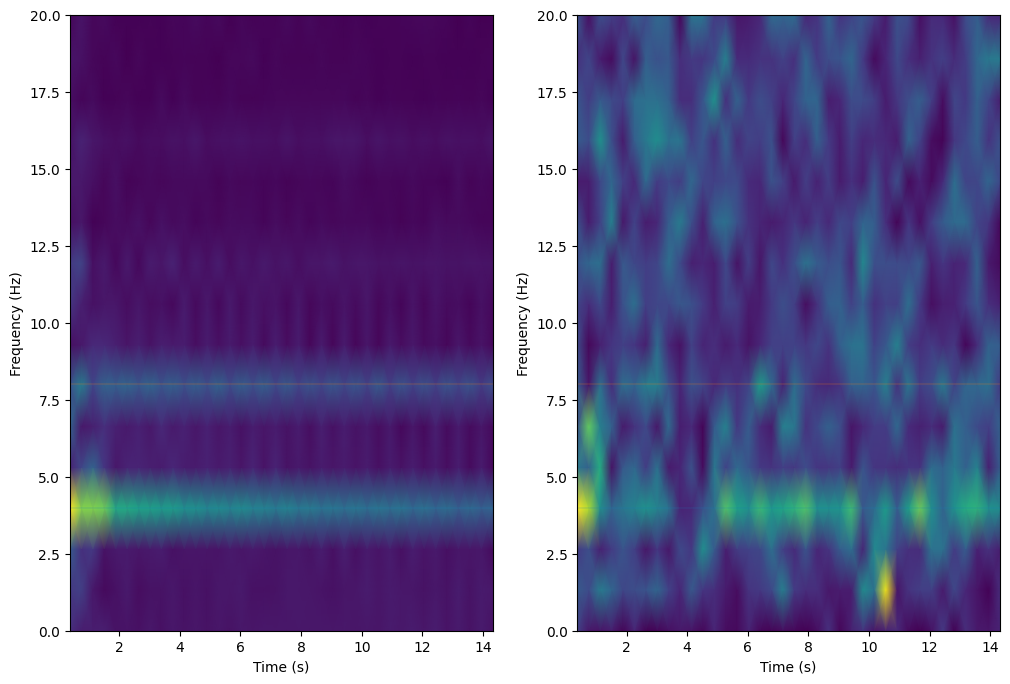

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].pcolormesh(t, f, np.abs(Sxx[:, 20, 20, :]), shading='gouraud')
ax[0].plot([np.min(t), np.max(t)],[4, 4], linewidth=0.2)
ax[0].plot([np.min(t), np.max(t)],[8, 8], linewidth=0.2)
ax[0].set_ylim([0, 20])
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_xlabel('Time (s)')

ax[1].pcolormesh(t, f, np.abs(Sxx[:, 60, 60, :]), shading='gouraud')
ax[1].plot([np.min(t), np.max(t)],[4, 4], linewidth=0.2)
ax[1].plot([np.min(t), np.max(t)],[8, 8], linewidth=0.2)
ax[1].set_ylim([0, 20])
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

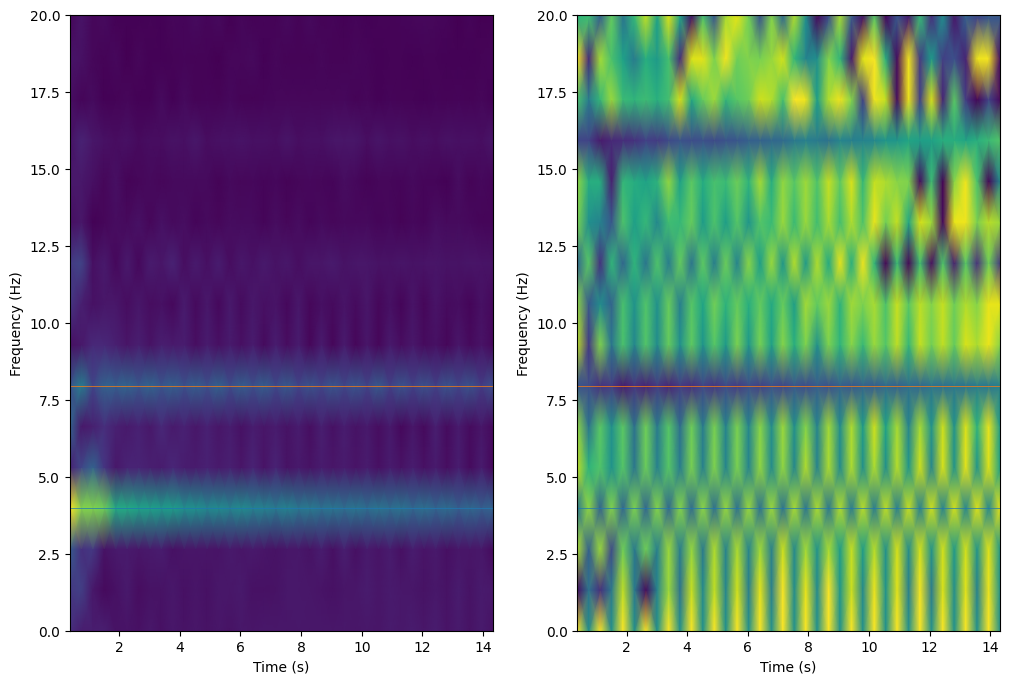

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].pcolormesh(t, f, np.abs(Sxx[:, 20, 20, :]), shading='gouraud')
ax[0].plot([np.min(t), np.max(t)], [f[3], f[3]], linewidth=0.5)
ax[0].plot([np.min(t), np.max(t)], [f[6], f[6]], linewidth=0.5)
ax[0].set_ylim([0, 20])
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_xlabel('Time (s)')

ax[1].pcolormesh(t, f, np.angle(Sxx[:, 20, 20, :]), shading='gouraud')
ax[1].plot([np.min(t), np.max(t)], [f[3], f[3]], linewidth=0.5)
ax[1].plot([np.min(t), np.max(t)], [f[6], f[6]], linewidth=0.5)
ax[1].set_ylim([0, 20])
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlabel('Time (s)')

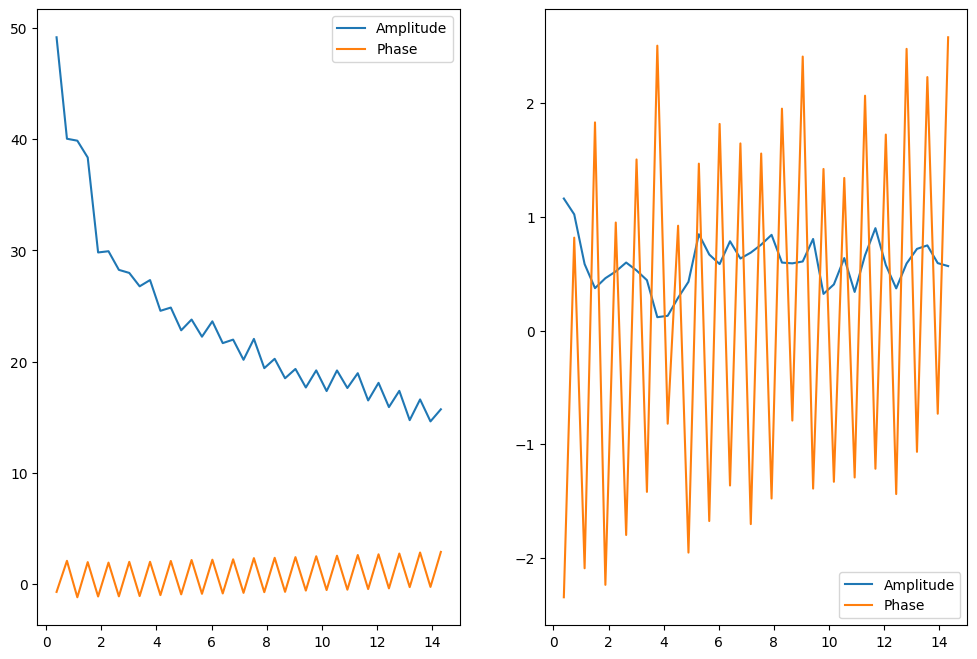

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].plot(t, np.abs(Sxx[3, 20, 20, :]))
ax[0].plot(t, np.angle(Sxx[3, 20, 20, :]))
ax[0].legend(['Amplitude', 'Phase'])

ax[1].plot(t, np.abs(Sxx[3, 60, 60, :]))
ax[1].plot(t, np.angle(Sxx[3, 60, 60, :]))
ax[1].legend(['Amplitude', 'Phase'])

## Time it takes to calculate the Fourier Transform 

In [18]:
min_cycles = 2 # The number of oscillations to integrate before filtering
min_frames = int(freq/max_freq) # How many frames to record a full oscillation
cycle_frames = min_frames*min_cycles # How many frames there are in the total integration period

to_analyze = np.copy(data[:cycle_frames, :, :])

In [19]:
%%timeit

c_fft = fft(to_analyze, axis=0)

32.4 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Time it takes to filter by a given frequency

In [21]:
%%timeit

c_filter = extract_amplitude_phase(to_analyze, 4, 340)

1.55 ms ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [20]:
c_filter = extract_amplitude_phase(to_analyze, 4, 340)

In [17]:
plt.imshow(np.abs(c_fft[4, :, :]))

NameError: name 'c_fft' is not defined

# Let's filter the data

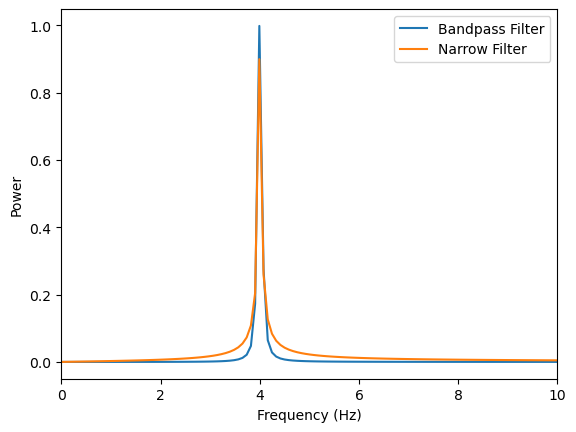

In [11]:
center_freq = max_freq
lowcut = center_freq*.99
highcut = center_freq*1.01
butter_order = 2
Q_factor = 100
fs = freq

b, a = butter_bandpass(lowcut, highcut, freq, order=butter_order)
w, h = freqz(b, a, worN=2000)
plt.plot((fs * 0.5 / np.pi) * w, abs(h))

b, a = narrow_bandpass(center_freq, Q_factor, fs)
w, h = freqz(b, a, worN=2000)
plt.plot((fs * 0.5 / np.pi) * w, abs(h))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim(0,10)
plt.legend(['Bandpass Filter', 'Narrow Filter'])

In [12]:
butter_filtered = butter_bandpass_filter(data, lowcut, highcut, fs, order=butter_order, axis=0)
narrow_filtered = narrow_bandpass_filter(data, center_freq, Q_factor, fs, axis=0)

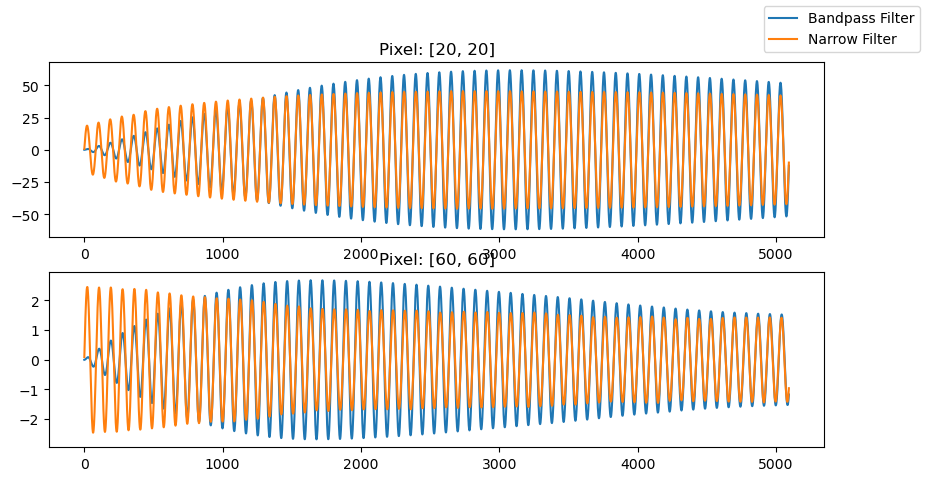

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].set_title('Pixel: [20, 20]')
ax[0].plot(butter_filtered[:, 20, 20])
ax[0].plot(narrow_filtered[:, 20, 20])

ax[1].set_title('Pixel: [60, 60]')
ax[1].plot(butter_filtered[:, 60, 60])
ax[1].plot(narrow_filtered[:, 60, 60])

fig.legend(['Bandpass Filter', 'Narrow Filter'])

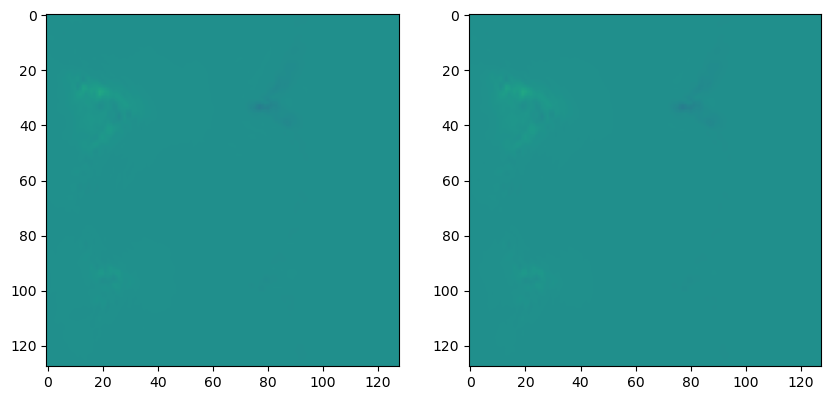

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(butter_filtered[2000, ...], vmin=np.min(butter_filtered), vmax=np.max(butter_filtered))
ax[1].imshow(narrow_filtered[2000, ...], vmin=np.min(narrow_filtered), vmax=np.max(narrow_filtered))


KeyboardInterrupt



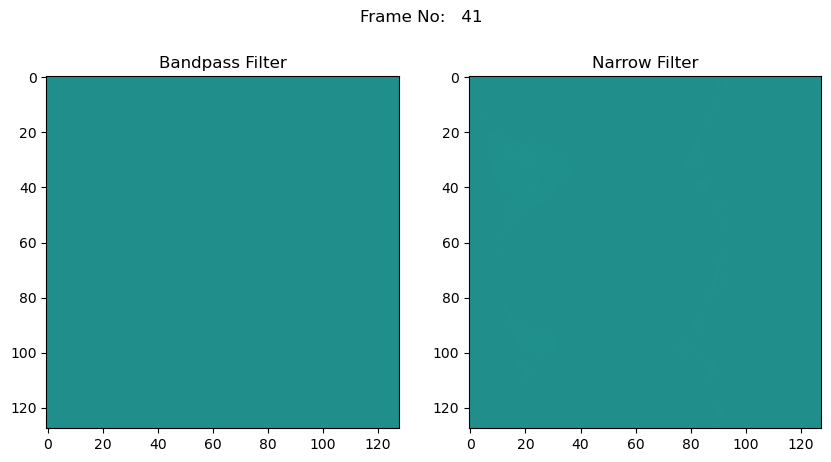

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(butter_filtered[0, ...], vmin=np.min(butter_filtered), vmax=np.max(butter_filtered))
im1 = ax[1].imshow(narrow_filtered[0, ...], vmin=np.min(narrow_filtered), vmax=np.max(narrow_filtered))
ax[0].set_title('Bandpass Filter')
ax[1].set_title('Narrow Filter')

def init():
    im0.set_data(butter_filtered[0,...])
    im1.set_data(narrow_filtered[0,...])
b
def animate(i):
    fig.suptitle(f'Frame No: {i:4}')
    im0.set_data(butter_filtered[i,...])
    im1.set_data(narrow_filtered[i,...])
    return ax

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=data.shape[0], interval=10)
anim.save('movie.mp4')

In [16]:
min_cycles = 3 # The number of oscillations to integrate before filtering
min_frames = int(freq/max_freq) # How many frames to record a full oscillation
cycle_frames = min_frames*min_cycles # How many frames there are in the total integration period

In [17]:
cycle_frames

252

In [18]:
small_data = data[:cycle_frames, :, :]

In [129]:
%%timeit
small_bandpass = butter_bandpass_filter(small_data, lowcut, highcut, fs, order=butter_order, axis=0)

58.6 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [130]:
%%timeit
small_narrow = narrow_bandpass_filter(small_data, center_freq, Q_factor, fs, axis=0)

45.4 ms ± 238 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
